# Single Transmon Qubit Simulator
### James Saslow
### 1/16/2024

The Hamiltonian for a single qubit can be described by the sum of a qubit Hamiltonian $H_{0}$ and a drive Hamiltonian $H_{d}$

$H = H_{0} + H_{d}$

where $H_{0} = -\frac{-\omega_{q}}{2} \sigma_{z}$ and $H_{d} = \Omega V_{d}(t) \sigma_{y}$

I'll define all these variables above.

- $\omega_{q}$ is the qubit frequency defined by the first two energy levels of the Transmon i.e. $E_{1} - E_{0} = \hbar \omega_{q}$

- $\sigma_{x}$, $\sigma_{y}$, and $\sigma_{z}$ are the usual Pauli Spin Matrices (https://en.wikipedia.org/wiki/Pauli_matrices)

- $\Omega$ is a parameter defined by the capacitances and impedance of the Transmon circuit (https://arxiv.org/abs/1904.06560 Pg 28)

- $V_d(t)$ is the microwave resonator written in terms of a driving time-dependent voltage source. In this notebook, I will define $V_d(t)$ to be a sinusoidal voltage encased in a Gaussian envelope.



In [2]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

from matplotlib.animation import FuncAnimation
import matplotlib
from ipywidgets import interact, widgets

# %matplotlib notebook

In [3]:
class Transmon:
    
    # ===== Pauli Spin Matrices =====
    
    sigma_y = np.array([[0,-1j],
                        [1j,0]])
    
    sigma_z = np.array([[1,0],
                        [0,-1]])
    # ===============================   
    
    def __init__(self,t,psi,wq,W,mu,stdev,V0,delta,wd):
        self.t     = t
        self.psi   = psi
        self.wq    = wq
        self.W     = W
        self.mu    = mu
        self.stdev = stdev
        self.V0    = V0
        self.delta = delta
        self.wd    = wd
        
    def get(self):
        psi = self.psi
        return psi

    # ============ Defining Function For AWG Voltage Pulse ===========    
    def voltage(self,t):
        mu = self.mu
        stdev = self.stdev
        V0 = self.V0
        wd = self.wd
        delta = self.delta
        
        # Envelope Function
        def envelope(t):
            norm = 1/(stdev*np.sqrt(2*np.pi))
            arg1 = (t-mu)/stdev
            arg2 = -0.5*arg1**2
            return norm*np.exp(arg2)
        
        return V0 * envelope(t) * np.sin(wd*t + delta)
    # ================================================================
    
    
    def voltage_plot(self):
        t = self.t
        V = self.voltage(t)
        
        plt.figure(figsize = (6,4))
        plt.title('Voltage vs Time')
        plt.plot(t,V)
        plt.xlabel('Time')
        plt.ylabel('Voltage')
        plt.show()
        
    
    def run(self):
        '''
        Running simulation of time evolution of the qubit 
        '''
        t     = self.t
        psi   = self.psi
        wq    = self.wq
        W     = self.W
        mu    = self.mu
        stdev = self.stdev
        V0    = self.V0
        delta = self.delta
        wd    = self.wd
        
        sigma_y = self.sigma_y
        sigma_z = self.sigma_z
        
        
        # ============ Defining Functions for the Hamiltonian ============
        
        # Qubit Hamiltonian
        def H0(t):
            return -wq/2 * sigma_z
        
        # Drive Hamiltonian
        def Hd(t):
            Vd = self.voltage(t)
            return W * Vd * sigma_y
        
        # Total Hamiltonian
        def H(t):
            return H0(t) + Hd(t)
        # =========================================================================
        
        
        # ====== Differential Equation Solver (Runge-Kutta 4th Order Method) ======
        def f(r,t):    
            M = -1j*H(t)
            v = M@r # Array of Velocities
            return v


        def RK4(f,t,init):
            N = len(t)
            dt = t[1] - t[0]
            r = [init]
            for i in range(N-1):
                k1 = dt * f(r[i],t[i])
                k2 = dt * f(r[i] + 0.5*k1, t[i] + 0.5*dt)
                k3 = dt * f(r[i] + 0.5*k2, t[i] + 0.5*dt)
                k4 = dt * f(r[i] + k3, t[i] + dt)
                r.append(r[i] + (1/6) * (k1 + 2*k2 + 2*k3 + k4))
            return np.transpose(r)
        # =========================================================================
        
        
        # =========== Solving the TDSE ============
        init = psi
        sol  = RK4(f,t,init)
        self.psi = sol
        #==========================================
        
    def prob_plot(self):
        '''
        Plots probabilities of |0> and |1> with respect to time
        '''
        
        t   = self.t
        psi = self.psi
        
        a,b = psi
        prob_a = np.abs(a)**2
        prob_b = np.abs(b)**2
            
        plt.figure(figsize = (6,4))
        plt.title('Probability vs Time')
        plt.plot(t,prob_a, label = '$P_{|0>}$')
        plt.plot(t,prob_b, label = '$P_{|1>}$')
        plt.legend(loc = 'upper right')
        plt.xlabel('Time')
        plt.ylabel('Probability')
        plt.show()
        
    
    def bloch_sphere_angles(self):
        psi = self.psi
        a,b = psi
        theta = 2*np.arctan( np.abs(b) / np.abs(a) )
        phi = np.angle(b) - np.angle(a)
        return theta, phi
    
    
    def get_states(self):
        theta,phi = self.bloch_sphere_angles()
        theta_i = theta[0]
        phi_i   = phi[0]
        
        a_i = np.round(np.cos(theta_i/2),3)
        b_i = np.round(np.sin(theta_i/2)*np.exp(1j*phi_i),3)
        
        psi_i = str(a_i) + '|0> + ' + str(b_i) + '|1>'
        
        theta_f = theta[-1]
        phi_f   = phi[-1]
    
        a_f = np.round(np.cos(theta_f/2),3)
        b_f = np.round(np.sin(theta_f/2)*np.exp(1j*phi_f),3)
    
        psi_f = str(a_f) + ' |0> + ' + str(b_f) + '|1>'
        
        return psi_i,psi_f
        
    def theta_plot(self):
        t   = self.t
        psi = self.psi
        theta,phi = self.bloch_sphere_angles()
        
        plt.figure(figsize = (6,4))
        plt.plot(t,theta)
        plt.title('$\u03B8$' + ' vs Time')
        plt.xlabel('Time')
        plt.ylabel('$\u03B8$')
        plt.show()
        
        
    def phi_plot(self):
        t = self.t
        psi = self.psi
        theta,phi = self.bloch_sphere_angles()
        
        plt.figure(figsize = (6,4))
        plt.plot(t,phi)
        plt.title('\u03A6' + ' vs Time')
        plt.xlabel('Time')
        plt.ylabel('\u03A6')
        plt.show()
        
    
    def bloch_sphere_plot(self, **kwargs):
        
        psi = self.psi
        theta, phi = self.bloch_sphere_angles()
        
        size = [16,12]
        if 'size' in kwargs:
            size = kwargs['size']
        size1,size2 = size
        
        fig = plt.figure(figsize=(size1, size2)) 
        ax = fig.add_subplot(111, projection='3d')

        # Data for a three-dimensional line
        xline = np.sin(theta)*np.cos(phi)
        yline = np.sin(theta)*np.sin(phi)
        zline = np.cos(theta)

        ax.plot3D(xline, yline, zline, 'black', linewidth = 4, alpha = 0.8)
        
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")

        # Drawing the Bloch Sphere
        u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:40j]
        x = np.cos(u)*np.sin(v)
        y = np.sin(u)*np.sin(v)
        z = np.cos(v)
        ax.plot_wireframe(x, y, z, color="r", alpha = 0.3)
    
        
        psi_i_label='$|'+'\u03C8'+'>'+'_i$'
        psi_f_label='$|'+'\u03C8'+'>'+'_f$'
        wavefunction_bool = kwargs.get('wavefunction',False)
        if wavefunction_bool == True:
            psi_i,psi_f = self.get_states()
            psi_i_label += ('= ' + psi_i)
            psi_f_label += ('= ' + psi_f)
        
        
        ax.scatter3D(xline[0], yline[0], zline[0], s = 155, c='yellow', label = psi_i_label)
        ax.scatter3D(xline[-1], yline[-1], zline[-1], s = 155, c='blue', label = psi_f_label)
        
        axes_bool = kwargs.get('axes',False)
        if axes_bool == True:
            ax.plot3D([-1, 1], [0, 0], [0, 0], linestyle = '--',color = 'black' ,alpha = 0.6 ,linewidth=2)  # X-axis
            ax.plot3D([0, 0], [-1, 1], [0, 0], linestyle = '--',color = 'black' ,alpha = 0.6,linewidth=2)  # Y-axis
            ax.plot3D([0, 0], [0, 0], [-1, 1], linestyle = '--',color = 'black' ,alpha = 0.6,linewidth=2)  # Z-axis
        
        labels_bool = kwargs.get('labels', False)
        if labels_bool == True:
            fontsize = 1.7*np.mean(size)
            ax.text(1.5, 0, 0, "$|+>$", color='green', fontsize=fontsize, weight = 'bold',fontfamily='DejaVu Sans')
            ax.text(0, 0, 1.4, "$|0>$", color='green', fontsize=fontsize, weight = 'bold',fontfamily='DejaVu Sans')
            ax.text(0, 1.4, 0, "$|+i>$", color='green', fontsize=fontsize, weight = 'bold',fontfamily='DejaVu Sans')
        
        legend_bool = kwargs.get('legend', False)
        if legend_bool == True:
            ax.legend()
            
        ax.view_init(elev=20, azim=45)
        plt.axis('off')
        plt.show()

In [4]:
# Initial Conditions and time interval

def state_vec(theta, phi):
    return np.array([ np.cos(theta/2) , np.exp(1j*phi)*np.sin(theta/2) ])

t = np.linspace(0,6,10000)
psi = state_vec(0,0)

# Transmon Properties
wq = 20
W = 1

# Microwave Resonator Properties
stdev = 1
mu = 3
V0 = np.pi
delta = 0
wd = 20

In [5]:
myQubit = Transmon(t,psi,wq,W,mu,stdev,V0,delta,wd)
myQubit.run()

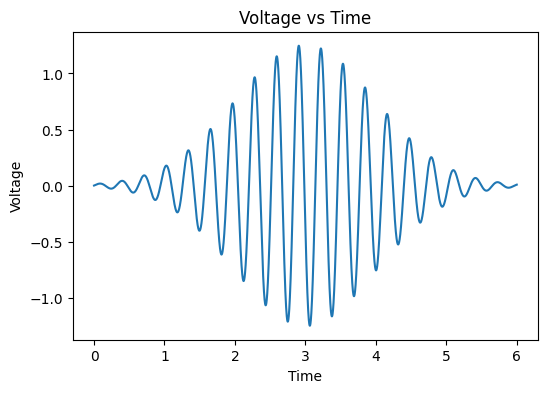

In [6]:
myQubit.voltage_plot()

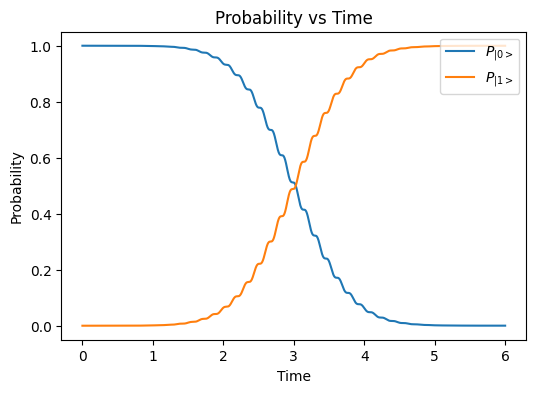

In [7]:
myQubit.prob_plot()

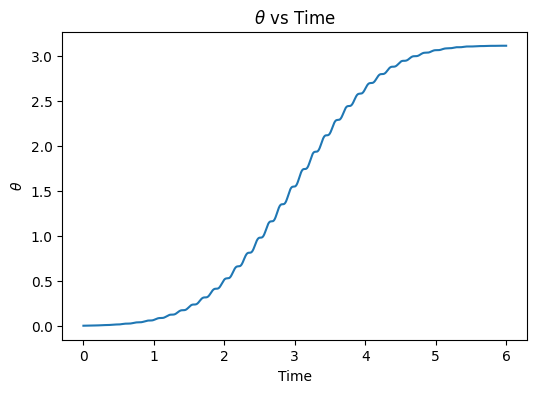

In [8]:
myQubit.theta_plot()

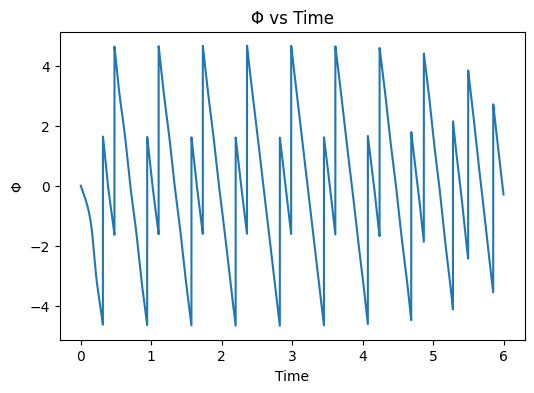

In [9]:
myQubit.phi_plot()

In [10]:
psi_initial,psi_final = myQubit.get_states()

print('Initial Psi =', psi_initial)
print('Final Psi = ', psi_final)

Initial Psi = 1.0|0> + 0j|1>
Final Psi =  0.014 |0> + (0.957-0.29j)|1>


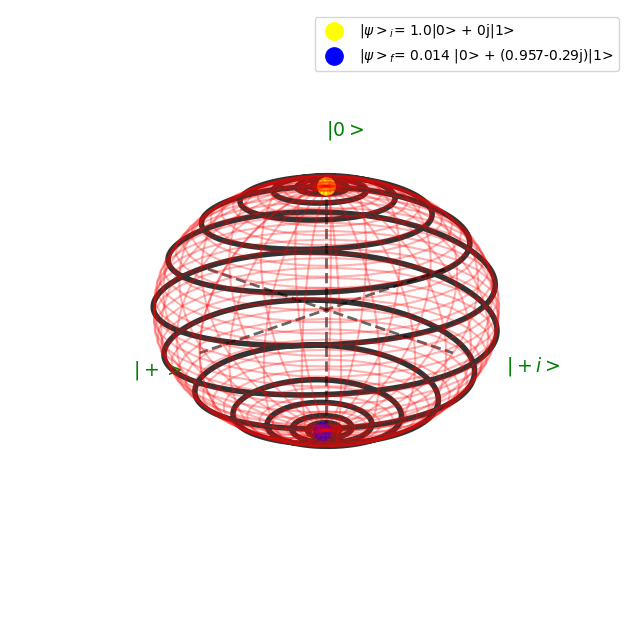

In [11]:
myQubit.bloch_sphere_plot(axes = True,labels = True, legend = True, wavefunction = True,size = [8,8])

In [12]:
def qubit_widget(wq, W, V0, delta, wd, tf,stdev):
    # Initial Conditions and time interval
    t = np.linspace(0, tf, 800)
    psi = state_vec(theta=0,phi = 0)

    # Creating Transmon Qubit
    myQubit = Transmon(t, psi, wq, W, mu, stdev, V0, delta, wd)
    myQubit.run()
    myQubit.bloch_sphere_plot(axes=True, labels=True, legend=True,wavefunction = True ,size = [7,7])
    
# Create interactive widget
widget = interact(qubit_widget,
                  wq=widgets.FloatSlider(value=23, min=0, max=30, step=1, description='$\u03C9_q$'),
                  W=widgets.FloatSlider(value=1, min=0, max=4, step=0.1, description='$\u03A9$'),
                  V0=widgets.FloatSlider(value=np.pi, min=0, max=4, step=0.1, description='$V_0$'),
                  delta=widgets.FloatSlider(value=0, min=-np.pi, max=np.pi+0.1, step=0.1, description='$\u03B4$'),
                  wd=widgets.FloatSlider(value=23, min=0, max=30, step=1, description='$\u03C9_d$'),
                  stdev=widgets.FloatSlider(value=1, min = 0.1, max = 1, step=0.1, description='$\u03C3$'),
                  tf=widgets.FloatSlider(value=6, min =0, max = 6, step=0.2,description = '$t_f$'))


plt.show()

interactive(children=(FloatSlider(value=23.0, description='$ω_q$', max=30.0, step=1.0), FloatSlider(value=1.0,…